# Physics-Informed Neural Networks (PINNs) — Simple Notes

## What is a PINN?

A **Physics-Informed Neural Network (PINN)** is a neural network that:
- tries to solve a differential equation,
- by learning a function that satisfies the equation,
- without needing lots of data.

Instead of fitting to data points only, PINNs try to make sure the network output:
- **matches initial conditions**
- **satisfies the PDE everywhere inside the domain**

---

## The problem

Suppose we want to solve a simple PDE:

$$\frac{\partial u}{\partial t} = \mathcal{N}[u]$$

The form can be changed to the residual form which is as follows:

$$ R[u(x,t)] = \frac{\partial u}{\partial t} - \mathcal{N}[u]  $$


where:
- $u = u(x, t)$ is the unknown function,
- $\mathcal{N}[u]$ is some expression (e.g. involves derivatives of $u$),
- domain: $x \in \mathbb{R}, t \ge 0$.

We know the initial condition:

$$u(x, 0) = u_0(x)$$

---

## What the PINN does

We build a neural network $u_\theta(x, t)$ where $\theta$ are the network parameters (weights + biases).

Our objective is such that the residual function upon using $u_\theta(x, t)$ instead of $u(x, t)$ should result approximately 0.

$$ R[u_\theta(x, t)] \approx 0 $$
$$ \frac{\partial u_\theta}{\partial t}(x,t) - \mathcal{N}[u_\theta(x,t)] \approx 0 $$

This is done by gradient descent and backpropagation in the neural network which optimises the network parameters.

---

## The PINN loss

### 1️⃣ PDE loss

We choose points $(x_i, t_i)$ inside the domain ("collocation points").  
The indexing purely makes it easier to sample points. As long as $(x, t) \in D$, any combination of $(x_i, t_j)$ can be used. Indexing makes it much simpler to program.
We want the PDE to be satisfied at these points:

$$\mathcal{L}_{\text{PDE}} = \frac{1}{N_r} \sum_{i=1}^{N_r} 
\left| \frac{\partial u_\theta}{\partial t}(x_i, t_i) - \mathcal{N}[u_\theta](x_i, t_i) \right|^2$$

---

### 2️⃣ Initial condition loss

We choose points $x_i^0$ at $t = 0$:

$$\mathcal{L}_{\text{IC}} = \frac{1}{N_0} \sum_{i=1}^{N_0} 
\left| u_\theta(x_i^0, 0) - u_0(x_i^0) \right|^2$$

---

### ✅ Total loss

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{PDE}} + \mathcal{L}_{\text{IC}}$$

We train the network to **minimize** this loss.

---

## Training steps

1️⃣ Pick some random points in the domain (collocation points) → for $\mathcal{L}_{\text{PDE}}$  
2️⃣ Pick points for initial condition → for $\mathcal{L}_{\text{IC}}$  
3️⃣ Compute the total loss  
4️⃣ Use gradient descent (like Adam) to update $\theta$

---

## Example PDE: 1D heat equation

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

where:
- $\alpha$ is a constant (thermal diffusivity)

The PINN tries to satisfy this equation at all points.

---

## Summary

✅ **No boundary conditions** — we only care about:
- PDE residual at points inside the domain
- matching initial condition at $t=0$

✅ The network learns a function $u_\theta(x,t)$ that solves the PDE!

---


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
import math

In [3]:
class PINN(nn.Module):

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1)

        )
        
    def forward(self,x):
        return self.net(x)
        

In [4]:
def residual(x,y_hat):
    dy_dx = torch.autograd.grad(
        y_hat, x, grad_outputs=torch.ones_like(y_hat), create_graph=True
    )
    return dy_dx[0] + 2* y_hat - torch.sin(x)



Epoch 0, Loss: 1.097597
Epoch 200, Loss: 0.000537
Epoch 400, Loss: 0.000178
Epoch 600, Loss: 0.000139
Epoch 800, Loss: 0.000119
Epoch 1000, Loss: 0.000100
Epoch 1200, Loss: 0.000083
Epoch 1400, Loss: 0.000067
Epoch 1600, Loss: 0.000053
Epoch 1800, Loss: 0.000040


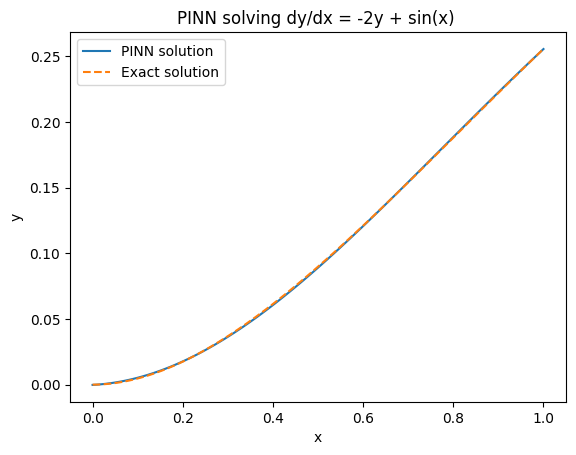

In [5]:
model = PINN()
optimizer = optim.Adam(model.parameters(), lr = 0.01)
N_train = 100
x_train = torch.linspace(0,1,N_train).view(-1,1)
x_train.requires_grad = True
n_epochs = 2000
y_of_0 = 0

for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_hat = model(x_train)
    res = residual(x_train, y_hat)
    physical_loss = torch.mean(res**2)
    y_hat_for_0 = model(torch.tensor([[0.0]]))
    IC_loss = (y_hat_for_0 - y_of_0)**2
    
    loss = physical_loss + IC_loss
    loss.backward()
    optimizer.step()

    if epoch % (n_epochs//10) == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')

x_test = torch.linspace(0, 1, 100).view(-1,1)
with torch.no_grad():
    y_pred = model(x_test)

y_exact = (2*torch.sin(x_test) - torch.cos(x_test) + torch.exp(-2*x_test))/5

plt.plot(x_test.numpy(), y_pred.numpy(), label='PINN solution')
plt.plot(x_test.numpy(), y_exact.numpy(), '--', label='Exact solution')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('PINN solving dy/dx = -2y + sin(x) ')
plt.show()
    